In [57]:
from scipy.io import loadmat
import numpy as np
import matplotlib.pyplot as plt
import glob
from sklearn.decomposition import PCA

import sys
sys.path.append("../../ibl_analyses/scripts")
sys.path.append("../../siegel_analyses/scripts/")
import netrep_helpers as nh
import utils
from sklearn.manifold import MDS
from scikits.bootstrap import bootstrap as bt
from scipy.stats import ttest_ind
import tqdm
import seaborn as sns
from netrep.metrics import LinearMetric
from netrep.utils import whiten, angular_distance
import imp
imp.reload(utils)
from netrep.utils import align

import scipy.stats as sts
import matplotlib as mpl
new_rc_params = {'text.usetex': False,
"svg.fonttype": 'none'
}
mpl.rcParams.update(new_rc_params)


In [58]:
sessions_1 = glob.glob('../Dataset_1/*')
sessions_2 = glob.glob('../Dataset_2/*')
sessions_3 = glob.glob('../Dataset_3/*')

sessions = sessions_1 + sessions_2 #+ sessions_3

## load data in sepated folds

In [59]:

HD_fold = []
n_folds = 100
n_pcs = 20
pca = PCA(n_components=n_pcs)


total_neurons = []
all_data = []
for session in tqdm.tqdm(sessions):

    # tuning curves computed with two halves of the behavioral data (same neurons)
    hd_data = loadmat(session + '/Analysis/HdTuning_xval_moveEp.mat')

    data_1 = hd_data["hAll1"][:,:,12]# last index is smoothing window. 12 seems great
    data_2 = hd_data["hAll2"][:,:,12]

    total_neurons.append(data_1.shape[1])
    N = len(data_1[0])
    if N < 40:
        continue

    all_data += [data_1]
    all_data += [data_2]
    #all_data += [data_1/2+data_2/2]
    idx = np.arange(N)
    many_folds = []
    for fold in range(n_folds):

        np.random.shuffle(idx)
        pcs_1 = pca.fit_transform(data_1[:,idx[:N//2]])   
        pcs_2 = pca.fit_transform(data_2[:,idx[N//2:]])
        
        many_folds.append([pcs_1,pcs_2])

    HD_fold.append(many_folds)

    # cv in time


sh = np.shape(HD_fold)
HD_many_folds = np.array(HD_fold).transpose(1,0,2,3,4).reshape(sh[1],-1,sh[3],sh[4])
HD_fold  = HD_many_folds[0]


100%|██████████| 31/31 [00:12<00:00,  2.51it/s]


In [60]:
S=len(sessions)
print(S)

S_tot = len(HD_fold)
print(S_tot)

31
62


## calcualte distances within (different folds) and across animals 

In [61]:
imp.reload(utils)

#neural folds
many_dist_neural_alpha_0 = []
many_dist_neural_alpha_1 = []
for fold in tqdm.tqdm(HD_many_folds):

    dist_neural_alpha_0 = np.zeros((S_tot,S_tot))*np.nan
    dist_neural_alpha_1 = np.zeros((S_tot,S_tot))*np.nan
    for i in range(len(fold)):
        for j in range(i,len(fold)):
 
            dist_neural_alpha_0[i,j]=dist_neural_alpha_0[j,i]=utils.dsd([[fold[i],fold[j]]],alpha=0)
            dist_neural_alpha_1[i,j]=dist_neural_alpha_1[j,i]=utils.dsd([[fold[i],fold[j]]],alpha=1)

    many_dist_neural_alpha_0.append(dist_neural_alpha_0)
    many_dist_neural_alpha_1.append(dist_neural_alpha_1)


# just to ensure symmetry. Somehow alpha=0 is slightly not symmetric
dist_neural_alpha_0 = (dist_neural_alpha_0+dist_neural_alpha_0.T)/2
dist_neural_alpha_1 = (dist_neural_alpha_1+dist_neural_alpha_1.T)/2


100%|██████████| 100/100 [30:47<00:00, 18.47s/it]


## plot inter animal variability analyses

[365.51535101 375.63059514]
[279.01577839 337.69013519]
TtestResult(statistic=15.32350039637095, pvalue=7.052916091121414e-28, df=99)
TtestResult(statistic=118.07248110864954, pvalue=2.475326432373327e-108, df=99)


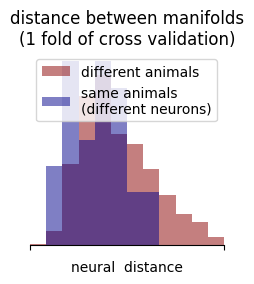

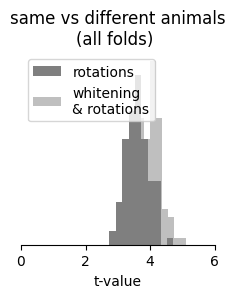

In [66]:

# cv neural

fig = plt.figure(figsize=(2.5,2.5))

all_tests_0 = []
all_tests_1 = []
for di,dist in enumerate(many_dist_neural_alpha_0):

    other_dists = dist[np.triu_indices(S_tot,2)].reshape(-1)
    between_folds = dist[range(0,S_tot,2),range(1,S_tot,2)]
    t,p = ttest_ind(other_dists,between_folds)
    all_tests_0.append([t,p])

    dist = many_dist_neural_alpha_1[di]
    other_dists = dist[np.triu_indices(S_tot,2)].reshape(-1)
    between_folds = dist[range(0,S_tot,2),range(1,S_tot,2)]
    t,p = ttest_ind(other_dists,between_folds)
    all_tests_1.append([t,p])

plt.hist(other_dists,density=True,bins=np.linspace(0,700,15),alpha=0.5,label="different animals",color='darkred')
plt.hist(between_folds,density=True,bins=np.linspace(0,700,15),alpha=0.5,label="same animals\n(different neurons)",color='darkblue')
plt.legend()

print(bt.ci(other_dists))
print(bt.ci(between_folds))

plt.title("distance between manifolds\n(1 fold of cross validation)")
sns.despine(left=True)
plt.yticks([])
plt.xticks([100,700],[])
plt.xlim([100,700])
plt.xlabel("neural  distance")
plt.savefig('../results/distances_1fold.svg')

fig = plt.figure(figsize=(2.5,2.5))
from scipy.stats import ttest_1samp,ttest_rel
print(ttest_rel(np.array(all_tests_0)[:,0],(np.array(all_tests_1)[:,0])))
print(ttest_1samp(np.array(all_tests_0)[:,0],0))

plt.hist(np.array(all_tests_1)[:,0],alpha=0.5,bins=10,label="rotations",color='black')
plt.hist(np.array(all_tests_0)[:,0],alpha=0.5,bins=10,label="whitening\n& rotations",color='gray')
plt.xlabel("t-value")
plt.title('same vs different animals\n(all folds) ')
plt.xlim(0,6)
plt.legend()
sns.despine()

sns.despine(left=True)
plt.yticks([])
plt.xlabel("t-value")
plt.savefig('../results/distances_all_folds.svg')

In [67]:
print(np.mean((np.array(all_tests_1)[:,0]).mean()>=np.array(all_tests_0)[:,0]))
print(np.mean((np.array(all_tests_1)[:,0])>np.array(all_tests_0)[:,0]).mean())

0.12
0.06


## regression in shape space analyses

/var/folders/6w/snfd5vc50jb775fq8364m1d80000gn/T/ipykernel_8441/1410417791.py:37: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all Axes decorations.
  fig.tight_layout()
/var/folders/6w/snfd5vc50jb775fq8364m1d80000gn/T/ipykernel_8441/1410417791.py:58: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all Axes decorations.
  fig.tight_layout()


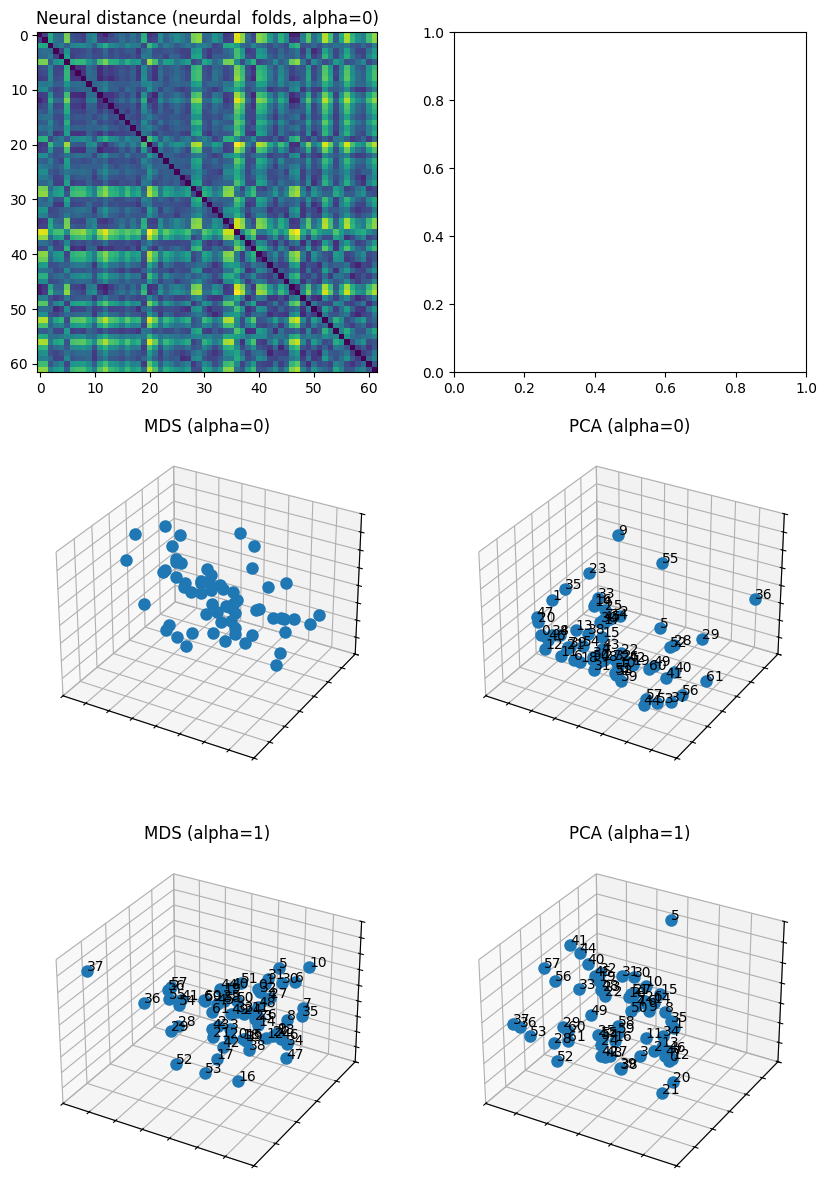

In [96]:

fig = plt.figure(figsize=(10,15))
ax = fig.add_subplot(321)

dist_mds_alpha_0 = MDS(n_components=30,dissimilarity="precomputed",normalized_stress=False).fit_transform(dist_neural_alpha_0) 
pca_dist_alpha_0 = PCA(n_components=10).fit_transform(dist_mds_alpha_0)

dist_mds_alpha_1 = MDS(n_components=30,dissimilarity="precomputed",normalized_stress=False).fit_transform(dist_neural_alpha_1) 
pca_dist_alpha_1 = PCA(n_components=10).fit_transform(dist_mds_alpha_1)



ax.title.set_text("Neural distance (neurdal  folds, alpha=0)")
ax.imshow(dist_neural_alpha_0)

ax = fig.add_subplot(322)
#ax.plot(pca_fit.explained_variance_ratio_)

ax = fig.add_subplot(323, projection='3d')
ax.set_title("MDS (alpha=0)")
# add numbers to points
#for i in range(S*2):
#    ax.text(dist_mds_alpha_0[i,0],dist_mds_alpha_0[i,1],dist_mds_alpha_0[i,2],str(i))
ax.plot(dist_mds_alpha_0[:,0],dist_mds_alpha_0[:,1],dist_mds_alpha_0[:,2],"o",ms=8)
ax.set_xticks(ax.get_xticks(),[])
ax.set_yticks(ax.get_yticks(),[])
ax.set_zticks(ax.get_zticks(),[])


ax = fig.add_subplot(324, projection='3d')
ax.set_title("PCA (alpha=0)")
for i in range(S*2):
    ax.text(pca_dist_alpha_0[i,0],pca_dist_alpha_0[i,1],pca_dist_alpha_0[i,2],str(i))
ax.plot(pca_dist_alpha_0[:,0],pca_dist_alpha_0[:,1],pca_dist_alpha_0[:,2],"o",ms=8)
ax.set_xticks(ax.get_xticks(),[])
ax.set_yticks(ax.get_yticks(),[])
ax.set_zticks(ax.get_zticks(),[])
fig.tight_layout()

ax = fig.add_subplot(325, projection='3d')
ax.set_title("MDS (alpha=1)")
# add numbers to points
for i in range(S*2):
    ax.text(dist_mds_alpha_1[i,0],dist_mds_alpha_1[i,1],dist_mds_alpha_1[i,2],str(i))
ax.plot(dist_mds_alpha_1[:,0],dist_mds_alpha_1[:,1],dist_mds_alpha_1[:,2],"o",ms=8)
ax.set_xticks(ax.get_xticks(),[])
ax.set_yticks(ax.get_yticks(),[])
ax.set_zticks(ax.get_zticks(),[])


ax = fig.add_subplot(326, projection='3d')
ax.set_title("PCA (alpha=1)")
for i in range(S*2):
    ax.text(pca_dist_alpha_1[i,0],pca_dist_alpha_1[i,1],pca_dist_alpha_1[i,2],str(i))
ax.plot(pca_dist_alpha_1[:,0],pca_dist_alpha_1[:,1],pca_dist_alpha_1[:,2],"o",ms=8)
ax.set_xticks(ax.get_xticks(),[])
ax.set_yticks(ax.get_yticks(),[])
ax.set_zticks(ax.get_zticks(),[])
fig.tight_layout()

In [103]:

dist_mds_alpha_1 = MDS(n_components=30,dissimilarity="precomputed",normalized_stress=False).fit_transform(dist_neural_alpha_1) 
pca_fit = PCA(n_components=2).fit(dist_mds_alpha_1)

pca_trans = pca_fit.transform(dist_mds_alpha_1)
pca_dist_alpha_0 = pca_fit.inverse_transform(pca_trans)


D = dist_mds_alpha_0.reshape(-1)
H = pca_dist_alpha_0.reshape(-1)
distortions = np.maximum( D / H, H / D)
np.median(distortions) # <- report this

1.0169037969012729

In [102]:
np.sum(pca_fit.explained_variance_ratio_[:2])

0.635443211678583

In [72]:
# dist_all_data_0 = np.zeros((S_tot,S_tot)) 
# dist_mds_alpha_1 = np.zeros((S_tot,S_tot))
# for i in range(0,len(all_data)):
#     for j in range(i,len(all_data)):

#         dist_all_data_0[i,j]=dist_all_data_0[j,i]=utils.dsd([[all_data[i],all_data[j]]],alpha=0)
#         dist_neural_alpha_1[i,j]=dist_neural_alpha_1[j,i]=utils.dsd([[all_data[i],all_data[j]]],alpha=1)


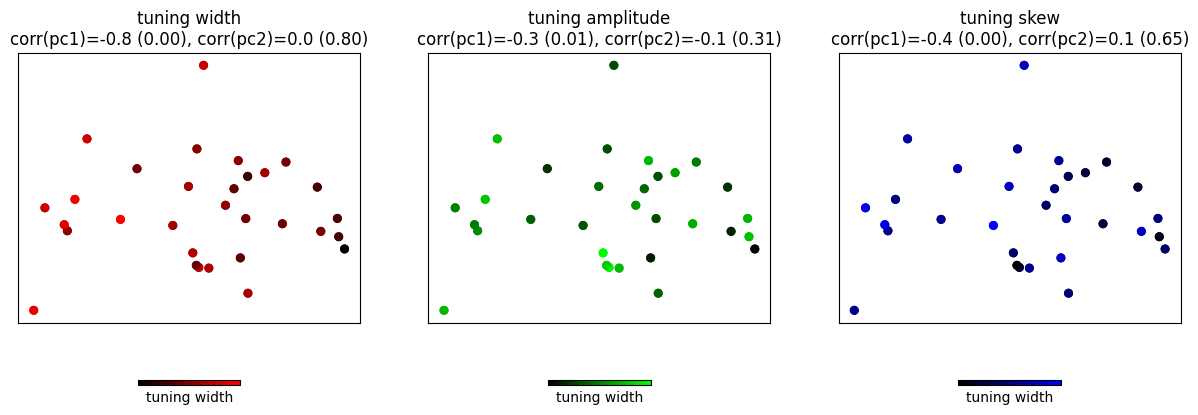

In [99]:
tuning_width = [np.mean(np.std(a,axis=0)) for a in all_data]
tuning_amp =[np.mean(np.mean(a,axis=0)) for a in all_data]
tuning_skew = [np.nanmean(sts.skew(a,axis=0)) for a in all_data]


from matplotlib.colors import LinearSegmentedColormap
names = ["tuning width","tuning amplitude","tuning skew"]
fig = plt.figure(figsize=(15,5))
for si,stat in enumerate([tuning_width,tuning_amp,tuning_skew]):
        stat = np.array(stat)
        color = [0, 0, 0]
        color[si] = 1
        colors = [(0, 0, 0), color] # first color is black, last is red
        cm = LinearSegmentedColormap.from_list(
                "Custom", colors, N=len(stat))

        ax = fig.add_subplot(1,3,si+1)#, projection='3d')

        #[plt.plot(pca_dist_alpha_1[i:i+2,0],pca_dist_alpha_1[i:i+2,1],pca_dist_alpha_1[i:i+2,2],'-',color='gray',alpha=0.3) for i in range(0,S_tot,2)]
        plt.plot(0,0,'-',color='gray',alpha=0.3,label="same animal (different fold)")

        sc = ax.scatter(pca_dist_alpha_1[range(0,S_tot,2),0],pca_dist_alpha_1[range(0,S_tot,2),1],c=stat[range(0,S_tot,2)],cmap=cm,s=30,alpha=1)

        #z= ax.get_zlim()[0]
        #sc = ax.scatter(pca_dist_alpha_1[:,0],pca_dist_alpha_1[:,1],z,color='gray',alpha=0.5)

        sc = ax.scatter(pca_dist_alpha_1[range(0,S_tot,2),0],pca_dist_alpha_1[range(0,S_tot,2),1],c=stat[range(0,S_tot,2)],cmap=cm,s=30)

        ax.set_xticks([])
        ax.set_yticks([])
        #ax.set_zticks([])
        #ax.axis('off')
        cbar=plt.colorbar(sc,orientation="horizontal",label="tuning width",shrink=0.3)
        cbar.set_ticks([])
        #plt.legend()
        plt.title('%s\ncorr(pc1)=%.1f (%.2f), corr(pc2)=%.1f (%.2f)' % (names[si],sts.pearsonr(pca_dist_alpha_1[:,0],stat)[0],sts.pearsonr(pca_dist_alpha_1[:,0],stat)[1],sts.pearsonr(pca_dist_alpha_1[:,1],stat)[0],sts.pearsonr(pca_dist_alpha_1[:,1],stat)[1]))
        plt.savefig("../results/MDS_distances_alpha0_%s.svg" % names[si],bbox_inches='tight')
                
        # ax.xaxis.pane.set_edgecolor('black')
        # ax.yaxis.pane.set_edgecolor('black')
        # ax.zaxis.pane.set_edgecolor('black')

       

In [97]:
#import linear regression
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score

def dec(X,y,test_size=0.5,n_folds=25):
    scores = np.zeros(n_folds)
    for fold in range(n_folds):
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size)
        reg = LinearRegression().fit(X_train, y_train)
        #scores[fold]=sts.pearsonr(reg.predict(X_test), y_test)[0]
        scores[fold]=r2_score(y_test,reg.predict(X_test))
        ##scores[fold]=reg.score(X_test,y_test)

    return scores


n_folds = 100
n_shuffles = 1000
scores = np.zeros([n_folds,3])
shuffle_scores = np.zeros([n_shuffles,3])

for si,stat in enumerate(tqdm.tqdm([tuning_width,tuning_amp,tuning_skew])):
    scores[:,si] = dec(pca_dist_alpha_1[range(0,S_tot,2),:2],np.array(stat)[range(1,S_tot,2)],n_folds=n_folds)
    for shuffle in range(n_shuffles):
        stat_s  = stat.copy()
        np.random.shuffle(stat_s)
        shuffle_scores[shuffle,si] = np.median(dec(pca_dist_alpha_1[range(0,S_tot,2),:2],np.array(stat_s)[range(1,S_tot,2)],n_folds=10))



100%|██████████| 3/3 [00:32<00:00, 10.82s/it]


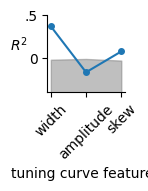

In [98]:
plt.figure(figsize=(1,1))
labels = ["width","amplitude","skew"]
plt.plot(labels,np.median(scores,0),'o-',ms=4,clip_on=False)
plt.fill_between(range(3),np.percentile(shuffle_scores,5,axis=0),np.percentile(shuffle_scores,95,axis=0),color='gray',alpha=0.5,label='shuffle')
plt.ylabel(r"$R^2$",rotation=0)
plt.xlabel('tuning curve features')
sns.despine()
plt.ylim(-0.4,0.5)
plt.yticks([0,0.5],['0','.5'])
plt.xticks(rotation=45)
#plt.legend()
# change color of legend text
#plt.legend(frameon=False)
plt.savefig("../results/MDS_distances_alpha0_regression.svg",bbox_inches='tight')
